In [1]:

import numpy as np
import pandas as pd

import nltk
from nltk.corpus import stopwords

import sys
import os

import gensim
from gensim.models import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
from gensim.matutils import corpus2csc

from pprint import pprint

import pyLDAvis
import pyLDAvis.gensim_models
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

import tqdm
import re
import nltk
import timeit

import warnings



In [2]:
mpox_df = pd.read_csv('mp1.csv')
mpox_df

,Unnamed: 0,Datetime,Tweet Id,Text,Username,Like Count,Reply Count,RetweetCount,Language,Hashtags,Source,text_cleaned,Hashtag_count,text_cleared,TextLen
0,0,2022-09-30 23:57:18,1575998250905040000,American Government: ‘The #monkeypox virus spr...,johnOkillens,0.0,0.0,1.0,en,monkeypox,"<a href=""http://twitter.com/#!/download/ipad"" ...",american government monkeypox virus spread slo...,1,american government spread slowing foresee fin...,182
1,1,2022-09-30 23:57:07,1575998207032630000,They stole my sons catalytic converter I hope ...,LordotDragons,6.0,0.0,0.0,en,NaN,"<a href=""http://twitter.com/download/iphone"" r...",stole son catalytic converter hope people ever...,0,stole son catalytic converter hope people ever...,94
2,2,2022-09-30 23:55:14,1575997730500970000,"In response to #monkeypox, @POTUS requested th...",LALGBTCenter,8.0,1.0,2.0,en,monkeypox,"<a href=""https://mobile.twitter.com"" rel=""nofo...",response monkeypox requested congress allocate...,1,response requested congress allocate 4 5 billi...,170
3,4,2022-09-30 23:54:01,1575997424266420000,Monkey pox just up and disappeared,_sewjazzy,0.0,0.0,0.0,en,NaN,"<a href=""http://twitter.com/download/iphone"" r...",monkey pox disappeared,0,disappeared,11
4,5,2022-09-30 23:53:28,1575997287804690000,@LovesCanada8 I hope it's not as scary as monk...,ohwaldie,2.0,0.0,0.0,en,NaN,"<a href=""https://mobile.twitter.com"" rel=""nofo...",hope scary monkey pox,0,hope scary,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
546523,689930,2022-05-07 13:19:03,1522929001958090000,Monkeypox \n\nMonkey. Pox.\n\nAt least TRY and...,DejaRu22,59.0,2.0,5.0,en,NaN,"<a href=""http://twitter.com/download/iphone"" r...",monkeypox monkey pox least try make seem half ...,0,least try make seem half believable bat soup w...,82
546524,689931,2022-05-07 13:16:03,1522928245557150000,Did Bill Gates not bang on about a monkey pox ...,RebornShelo,1.0,0.0,0.0,en,NaN,"<a href=""http://twitter.com/download/android"" ...",bill gate bang monkey pox outbreak last year,0,bill gate bang outbreak last year,33
546525,689932,2022-05-07 13:03:25,1522925067881130000,HOW MANY ILLEGAL BOAT MEN ENTERING THE UK HAVE...,The_UK_NeedsYou,4.0,0.0,1.0,en,NaN,"<a href=""https://mobile.twitter.com"" rel=""nofo...",many illegal boat men entering uk exposed monk...,0,many illegal boat men entering uk exposed case...,97
546526,689933,2022-05-07 12:53:50,1522922658513680000,@TheSun Monkey pox sounds like a name of an up...,Scorchio11,0.0,0.0,0.0,en,NaN,"<a href=""http://twitter.com/download/iphone"" r...",monkey pox sound like name upcoming liverpudli...,0,sound like name upcoming liverpudlian punk band,47


In [3]:
mpox_df.count()

Unnamed: 0       546528
Datetime         546528
Tweet Id         546528
Text             546528
Username         546528
Like Count       546528
Reply Count      546528
RetweetCount     546528
Language         546528
Hashtags         188021
Source           546528
text_cleaned     546528
Hashtag_count    546528
text_cleared     546528
TextLen          546528
dtype: int64

In [4]:
mpox_df.isna().sum()

Unnamed: 0            0
Datetime              0
Tweet Id              0
Text                  0
Username              0
Like Count            0
Reply Count           0
RetweetCount          0
Language              0
Hashtags         358507
Source                0
text_cleaned          0
Hashtag_count         0
text_cleared          0
TextLen               0
dtype: int64

In [5]:
mpox_df['text_cleared']

0         american government spread slowing foresee fin...
1         stole son catalytic converter hope people ever...
2         response requested congress allocate 4 5 billi...
3                                               disappeared
4                                                hope scary
                                ...                        
546523    least try make seem half believable bat soup w...
546524                    bill gate bang outbreak last year
546525    many illegal boat men entering uk exposed case...
546526      sound like name upcoming liverpudlian punk band
546527    case confirmed uk authority issue urgent healt...
Name: text_cleared, Length: 546528, dtype: object

In [6]:

#Converting date to datetime
import calendar
mpox_df['Datetime']=pd.to_datetime(mpox_df['Datetime'], errors='coerce')

mpox_df['Months']=mpox_df['Datetime'].dt.month

#Changing month numbers to their month names

Month = mpox_df['Months'].apply(lambda x: calendar.month_name[x])

mpox_df['Months'] = Month


### Topic Modelling - Unsupervised LDA 
---

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [8]:

# Load the tweets data
df = pd.read_csv('mp1.csv')

In [9]:
df.count()

Unnamed: 0       546528
Datetime         546528
Tweet Id         546528
Text             546528
Username         546528
Like Count       546528
Reply Count      546528
RetweetCount     546528
Language         546528
Hashtags         188021
Source           546528
text_cleaned     546528
Hashtag_count    546528
text_cleared     546528
TextLen          546528
dtype: int64

In [10]:
NUM_SAMPLES = 50000 # The number of sample to use 
sample_df = df.sample(NUM_SAMPLES, replace=False).reset_index(drop=True)
sample_df.shape

(50000, 15)

In [11]:
cv = CountVectorizer(max_df=0.75, min_df=2)
dtm = cv.fit_transform(sample_df['text_cleared'])

In [12]:
dtm

<50000x16279 sparse matrix of type '<class 'numpy.int64'>'
	with 482703 stored elements in Compressed Sparse Row format>

In [13]:
# We can also get all those words using the get_feature_names() function
feature_names = cv.get_feature_names_out()
len(feature_names) # show the total number of distinct words

16279

In [14]:
temp_file = pd.DataFrame(feature_names)
len(temp_file[0].unique())

16279

In [15]:
NUM_TOPICS = 20
LDA_model = LatentDirichletAllocation(n_components=NUM_TOPICS, max_iter=30, random_state=42)

LDA_model.fit(dtm)


LatentDirichletAllocation(max_iter=30, n_components=20, random_state=42)

In [16]:
import random 
for index in range(15):
    random_word_ID = random.randint(0, 6506)
    print(cv.get_feature_names()[random_word_ID])

07304
eating
bra
filming
deviant
clench
blocking
arrange
bean
2m
brainer
disposable
dramatically
arena
brittney


/Users/olusesiamoo/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [17]:
# Pick a single topic 
a_topic = LDA_model.components_[0]

# Get the indices that would sort this array
a_topic.argsort()

array([16278, 13840,  6821, ...,  5316, 13686, 14390])

In [18]:
top_20_words_indices = a_topic.argsort()[-20:]

for i in top_20_words_indices:
    print(cv.get_feature_names()[i])

ape
invited
gave
long
sale
build
pcr
corona
afraid
caught
huge
used
business
run
waiting
keep
eye
everyone
started
test


In [19]:
for i, topic in enumerate(LDA_model.components_):
    print("THE TOP {} WORDS FOR TOPIC #{}".format(20, i))
    print([cv.get_feature_names()[index] for index in topic.argsort()[-20:]])
    print("\n")

THE TOP 20 WORDS FOR TOPIC #0
['ape', 'invited', 'gave', 'long', 'sale', 'build', 'pcr', 'corona', 'afraid', 'caught', 'huge', 'used', 'business', 'run', 'waiting', 'keep', 'eye', 'everyone', 'started', 'test']


THE TOP 20 WORDS FOR TOPIC #1
['period', 'past', 'today', '21', 'line', 'one', 'said', 'time', 'funny', 'quarantine', 'next', 'good', 'happened', 'ago', 'month', 'two', 'last', 'year', 'week', 'day']


THE TOP 20 WORDS FOR TOPIC #2
['also', 'today', 'story', 'need', 'new', 'available', 'help', 'concerned', 'share', 'cdc', 'testing', 'outbreak', 'full', 'thread', 'information', 'treatment', 'dr', 'read', 'vaccination', 'smallpox']


THE TOP 20 WORDS FOR TOPIC #3
['mild', 'headline', 'tnxp', 'instead', 'say', 'govx', 'medium', 'infectious', 'stock', 'high', 'people', 'african', 'news', 'rate', 'play', 'siga', 'black', 'risk', 'watch', 'disease']


THE TOP 20 WORDS FOR TOPIC #4
['confirmed', 'official', 'report', 'infection', 'update', 'new', 'africa', 'state', '2022', 'first', '

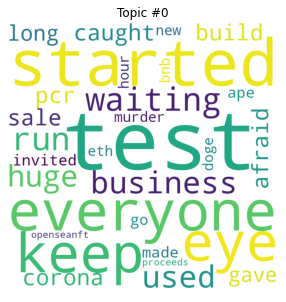

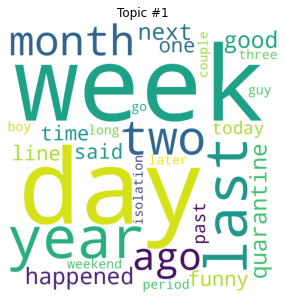

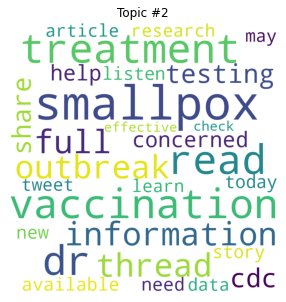

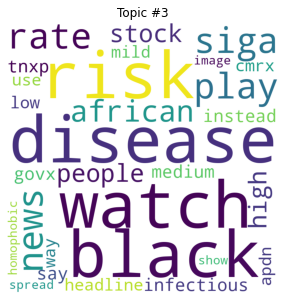

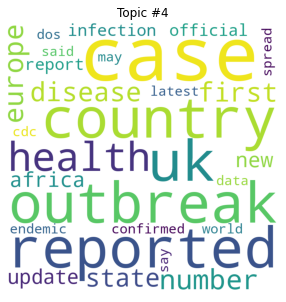

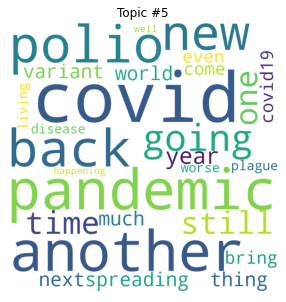

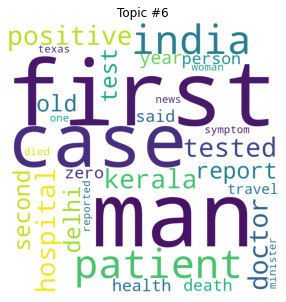

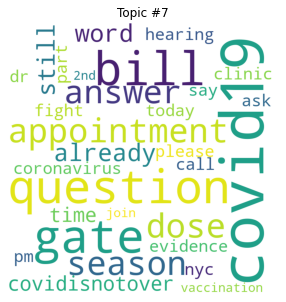

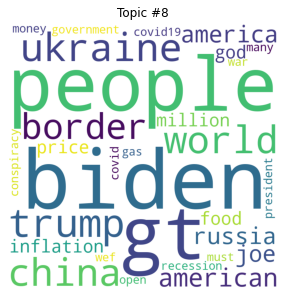

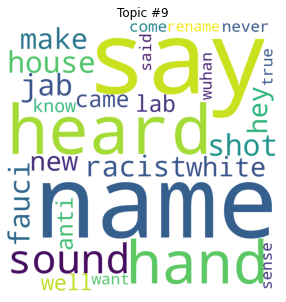

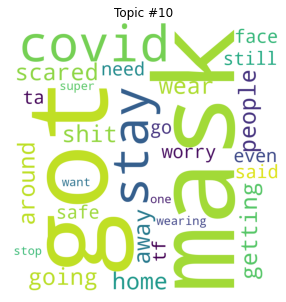

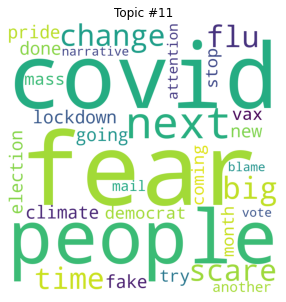

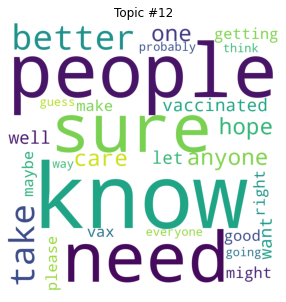

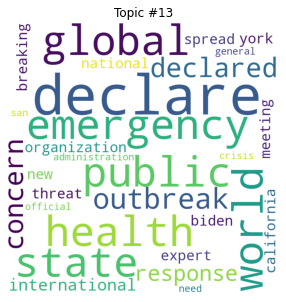

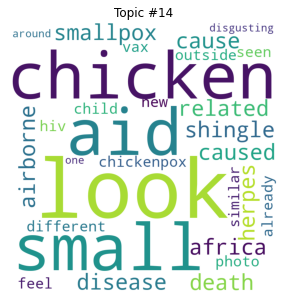

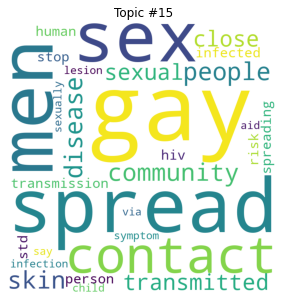

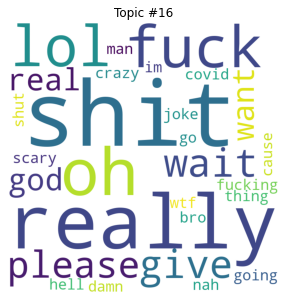

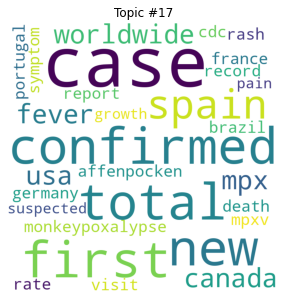

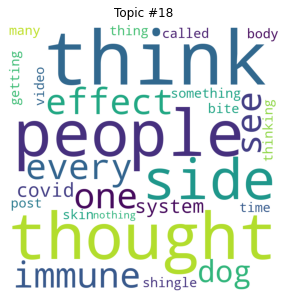

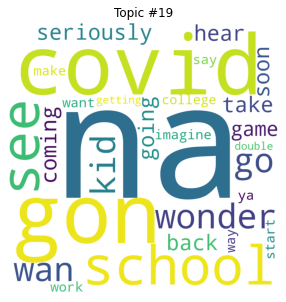

In [20]:
# Import the wordcloud library
from wordcloud import WordCloud

# Get the topic-word probability matrix
topic_word = LDA_model.components_

# Get the top words for each topic
n_top_words = 30
top_words = {}
for topic_idx, topic in enumerate(topic_word):
    top_words[topic_idx] = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
    
# Create the wordcloud
for topic, words in top_words.items():
    wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = None, 
                min_font_size = 10).generate(" ".join(words))
    plt.figure(figsize = (4, 4), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.title("Topic #" + str(topic))
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show()


In [21]:
final_topics = LDA_model.transform(dtm)
final_topics.shape

(50000, 20)

In [22]:
final_topics[4]

array([0.00384615, 0.00384615, 0.00384615, 0.00384615, 0.00384615,
       0.00384615, 0.00384615, 0.25588443, 0.00384615, 0.00384615,
       0.00384615, 0.1517334 , 0.45007448, 0.00384615, 0.00384615,
       0.00384615, 0.00384615, 0.08076923, 0.00384615, 0.00384615])

In [23]:
final_topics[3].argmax()

12

In [24]:
sample_df["Topic N°"] = final_topics.argmax(axis=1)

In [25]:
sample_df.head()

,Unnamed: 0,Datetime,Tweet Id,Text,Username,Like Count,Reply Count,RetweetCount,Language,Hashtags,Source,text_cleaned,Hashtag_count,text_cleared,TextLen,Topic N°
0,460101,2022-06-23 12:00:00,1539941338199820000,The World Health Organization is poised to dec...,AlArabiya_Eng,2.0,0.0,1.0,en,monkeypox,"<a href=""https://www.sprinklr.com"" rel=""nofoll...",world health organization poised decide whethe...,1,world health organization poised decide whethe...,147,13
1,500536,2022-06-07 22:52:54,1534307440333920000,Content analysis:\nThis article scores 53/100....,valurank,0.0,0.0,0.0,en,local monkeypox,"<a href=""https://help.twitter.com/en/using-twi...",content analysis article score 53 100 complete...,2,content analysis article score 53 100 complete...,70,7
2,477317,2022-06-15 17:17:26,1537122119011780000,@althiaraj People with China's CORONA and MONK...,RichardMak19,0.0,0.0,0.0,en,NaN,"<a href=""https://mobile.twitter.com"" rel=""nofo...",people china corona monkey business pox shall ...,0,people china corona business shall isolate period,49,1
3,493985,2022-06-09 15:31:21,1534921098051170000,There is no monkey pox disease in Michigan; pu...,anas26217517,0.0,0.0,0.0,en,NaN,"<a href=""http://publicize.wp.com/"" rel=""nofoll...",monkey pox disease michigan public health work...,0,disease michigan public health worker want kee...,51,12
4,129714,2022-08-09 02:45:02,1556833904308320000,@SkyNewsAust Matt Kean is shacked up with Adam...,Ozy_comsense,3.0,0.0,0.0,en,NaN,"<a href=""https://mobile.twitter.com"" rel=""nofo...",matt kean shacked adam green ant hope take car...,0,matt kean shacked adam green ant hope take car...,83,12


In [26]:
display = [1, 2, 3, 15]
df_4 = sample_df.iloc[:, display]
df_4

,Datetime,Tweet Id,Text,Topic N°
0,2022-06-23 12:00:00,1539941338199820000,The World Health Organization is poised to dec...,13
1,2022-06-07 22:52:54,1534307440333920000,Content analysis:\nThis article scores 53/100....,7
2,2022-06-15 17:17:26,1537122119011780000,@althiaraj People with China's CORONA and MONK...,1
3,2022-06-09 15:31:21,1534921098051170000,There is no monkey pox disease in Michigan; pu...,12
4,2022-08-09 02:45:02,1556833904308320000,@SkyNewsAust Matt Kean is shacked up with Adam...,12
...,...,...,...,...
49995,2022-07-11 14:01:56,1546495007196120000,@NorthwellHealth all appointments on fire isla...,5
49996,2022-08-04 19:00:19,1555267405986890000,.@dr_demetre: #Monkeypox public health emergen...,13
49997,2022-09-18 12:59:40,1571484098958620000,"@Marie24Dee John, You need to thank PM Holness...",7
49998,2022-07-30 03:28:04,1553220858285470000,ANGER\n\nWhile the notion of monkeypox affecti...,9


In [27]:
sample_df.Text[0]

'The World Health Organization is poised to decide whether to declare #monkeypox a global health emergency, stirring criticism from leading African scientists who say it has been a crisis in their region for years.\n\nhttps://t.co/2qbpWD5Pot'

In [33]:
!pip install --upgrade pip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 4.3 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: pip
    Found existing installation: pip 22.3.1
    Uninstalling pip-22.3.1:
      Successfully uninstalled pip-22.3.1


In [36]:
warnings.filterwarnings("ignore")
import pyLDAvis.sklearn
import pyLDAvis
import sklearn


panel = pyLDAvis.sklearn.prepare(LDA_model, dtm, cv) # Create the panel for the visualization
panel

pyLDAvis.display(panel)

In [37]:
pyLDAvis.save_html(panel, 'LDA_visualization.html')